# PySpark PyTorch Inference

### Image Classification
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'2.4.1'

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11595082.98it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 165746.48it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3671121.48it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16790262.05it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302510  [    0/60000]
loss: 2.290746  [ 6400/60000]
loss: 2.273581  [12800/60000]
loss: 2.270329  [19200/60000]
loss: 2.254656  [25600/60000]
loss: 2.228528  [32000/60000]
loss: 2.238483  [38400/60000]
loss: 2.210059  [44800/60000]
loss: 2.197927  [51200/60000]
loss: 2.178862  [57600/60000]
Test Error: 
 Accuracy: 44.1%, Avg loss: 2.171240 

Epoch 2
-------------------------------
loss: 2.172268  [    0/60000]
loss: 2.162264  [ 6400/60000]
loss: 2.116437  [12800/60000]
loss: 2.137667  [19200/60000]
loss: 2.081341  [25600/60000]
loss: 2.028898  [32000/60000]
loss: 2.055932  [38400/60000]
loss: 1.986404  [44800/60000]
loss: 1.982685  [51200/60000]
loss: 1.927453  [57600/60000]
Test Error: 
 Accuracy: 58.0%, Avg loss: 1.922579 

Epoch 3
-------------------------------
loss: 1.943846  [    0/60000]
loss: 1.917159  [ 6400/60000]
loss: 1.812734  [12800/60000]
loss: 1.857640  [19200/60000]
loss: 1.737204  [25600/60000]
loss: 1.690268  [32000/600

### Save Model State Dict
This is the [currently recommended save format](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

In [11]:
torch.save(model.state_dict(), "model_weights.pt")
print("Saved PyTorch Model State to model_weights.pt")

Saved PyTorch Model State to model_weights.pt


### Save Entire Model
This saves the entire model using python pickle, but has the [following disadvantage](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model):
> The serialized data is bound to the specific classes and the exact directory structure used when the model is saved... Because of this, your code can break in various ways when used in other projects or after refactors.

In [12]:
torch.save(model, "model.pt")

### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python).  However, this currently doesn't work with spark, which uses pickle serialization.

In [13]:
scripted = torch.jit.script(model)

In [14]:
scripted.save("model.ts")

### Load Model State

In [15]:
model_from_state = NeuralNetwork()
model_from_state.load_state_dict(torch.load("model_weights.pt")) # Load model weights to CPU by default.

/tmp/ipykernel_3595264/2512044506.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_from_state.load_state_dict(torch.load("model_weights.pt"))


<All keys matched successfully>

In [16]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Model

In [18]:
# Load model to original device (GPU) and move to CPU. 
new_model = torch.load("model.pt") 
new_model.to("cpu") 

/tmp/ipykernel_3595264/39731073.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model = torch.load("model.pt")


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [19]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = new_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [23]:
# Load model to original device (GPU) and move to CPU. 
ts_model = torch.jit.load("model.ts")
ts_model.to("cpu")

RecursiveScriptModule(
  original_name=NeuralNetwork
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (linear_relu_stack): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)

In [25]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = ts_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## PySpark

### Convert numpy dataset to Pandas DataFrame

In [26]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

In [27]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [28]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [29]:
pdf784 = pd.DataFrame(data)
pdf784

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.121569,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [30]:
%%time
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

CPU times: user 173 ms, sys: 56.2 ms, total: 229 ms
Wall time: 228 ms


,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
### Create Spark DataFrame from Pandas DataFrame

In [86]:
num_threads = 6

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "8g",
    "spark.executor.memory": "8g",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
}
spark = SparkSession.builder.appName("spark-dl-example")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

sc = spark.sparkContext

24/09/16 15:27:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [33]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema)

CPU times: user 217 ms, sys: 60.2 ms, total: 277 ms
Wall time: 2.33 s


In [34]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [35]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema)

CPU times: user 175 ms, sys: 56.4 ms, total: 231 ms
Wall time: 1.57 s


### Save the test dataset as parquet files

In [36]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_1")

24/09/16 15:03:19 WARN TaskSetManager: Stage 0 contains a task of very large size (5369 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 7.89 ms, sys: 0 ns, total: 7.89 ms
Wall time: 1.89 s


In [37]:
%%time
df784.write.mode("overwrite").parquet("fashion_mnist_784")

24/09/16 15:03:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/09/16 15:03:25 WARN TaskSetManager: Stage 1 contains a task of very large size (10457 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 8.02 ms, sys: 363 μs, total: 8.39 ms
Wall time: 1.55 s


### Check arrow memory configuration

In [38]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

## Inference using Spark DL API

### 1 columns of 784 float

In [43]:
import os
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [44]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [45]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [46]:
# get absolute path to model
model_dir = "{}/model.ts".format(os.getcwd())

In [61]:
def predict_batch_fn():
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using {} device".format(device))
    model = torch.jit.load(model_dir)
    model.to(device)
    
    def predict(inputs: np.ndarray):
        torch_inputs = torch.from_numpy(inputs).to(device)
        outputs = model(torch_inputs)
        return outputs.detach().cpu().numpy()
    
    return predict

In [62]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [63]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

Using cuda device
Using cuda device
Using cuda device
Using cuda device
Using cuda device
Using cuda device


CPU times: user 762 ms, sys: 128 ms, total: 891 ms
Wall time: 1.55 s


In [64]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 536 ms, sys: 101 ms, total: 637 ms
Wall time: 1.3 s


In [65]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 443 ms, sys: 135 ms, total: 578 ms
Wall time: 1.24 s


### Check predictions

In [66]:
predictions = preds[0].preds
img = preds[0].data

In [67]:
import matplotlib.pyplot as plt
import numpy as np

In [68]:
img = np.array(img).reshape(28,28)

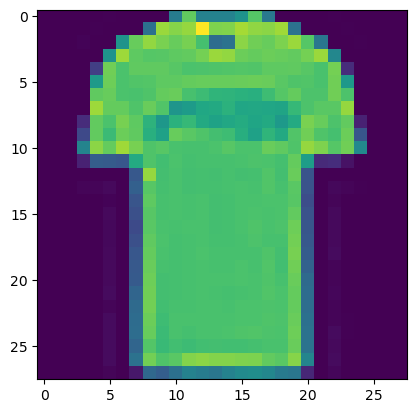

In [69]:
plt.figure()
plt.imshow(img)
plt.show()

In [72]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[3.8384504318237305, 1.2933310270309448, 1.3286985158920288, 2.6207523345947266, 1.4957536458969116, -3.2776546478271484, 2.257317304611206, -4.6599555015563965, -1.1901979446411133, -2.866666078567505]
predicted label: T-shirt/top


### 784 columns of float

In [73]:
df = spark.read.parquet("fashion_mnist_784")
len(df.columns)

784

In [74]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

Using cuda device                                                   (0 + 6) / 6]
Using cuda device
Using cuda device
Using cuda device
Using cuda device
Using cuda device


CPU times: user 684 ms, sys: 123 ms, total: 807 ms
Wall time: 8.45 s


In [75]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 1.02 s, sys: 123 ms, total: 1.14 s
Wall time: 2.58 s


### Check predictions

In [77]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [78]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [79]:
import matplotlib.pyplot as plt
import numpy as np

In [80]:
img = np.array(img).reshape(28,28)

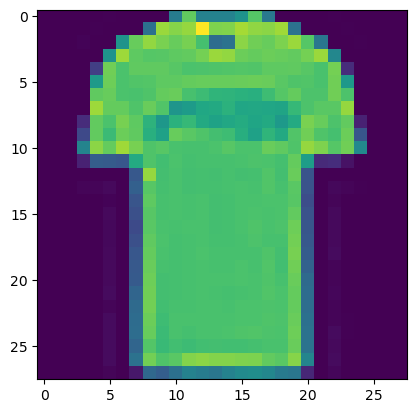

In [81]:
plt.figure()
plt.imshow(img)
plt.show()

In [82]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[ 3.83845    1.2933313  1.3286985  2.6207523  1.4957536 -3.277655
  2.2573178 -4.6599555 -1.1901978 -2.866666 ]
predicted label: T-shirt/top


### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [83]:
import numpy as np

from functools import partial
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [84]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/fashion_mnist/1
cp model.ts models/fashion_mnist/1/model.pt

# add config.pbtxt
cp models_config/fashion_mnist/config.pbtxt models/fashion_mnist/config.pbtxt

#### Start Triton Server on each executor

In [87]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:22.07-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

24/09/16 15:28:08 ERROR Executor: Exception in task 0.0 in stage 16.0 (TID 76)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connectionpool.py", line 495, in _make_request
    conn.request(
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connection.py", line 441, in request
    self.endheaders()
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 1298, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 1058, in _send_output
    self.send(msg)
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/p

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Could not recover from a failed barrier ResultStage. Most recent failure reason: Stage failed because barrier task ResultTask(16, 0) finished unsuccessfully.
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connectionpool.py", line 495, in _make_request
    conn.request(
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connection.py", line 441, in request
    self.endheaders()
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 1298, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 1058, in _send_output
    self.send(msg)
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 996, in send
    self.connect()
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/transport/unixconn.py", line 26, in connect
    sock.connect(self.unix_socket)
PermissionError: [Errno 13] Permission denied

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/requests/adapters.py", line 667, in send
    resp = conn.urlopen(
           ^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connectionpool.py", line 843, in urlopen
    retries = retries.increment(
              ^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/util/retry.py", line 474, in increment
    raise reraise(type(error), error, _stacktrace)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/util/util.py", line 38, in reraise
    raise value.with_traceback(tb)
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connectionpool.py", line 495, in _make_request
    conn.request(
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/urllib3/connection.py", line 441, in request
    self.endheaders()
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 1298, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 1058, in _send_output
    self.send(msg)
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/http/client.py", line 996, in send
    self.connect()
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/transport/unixconn.py", line 26, in connect
    sock.connect(self.unix_socket)
urllib3.exceptions.ProtocolError: ('Connection aborted.', PermissionError(13, 'Permission denied'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/api/client.py", line 223, in _retrieve_server_version
    return self.version(api_version=False)["ApiVersion"]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/api/daemon.py", line 181, in version
    return self._result(self._get(url), json=True)
                        ^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/utils/decorators.py", line 44, in inner
    return f(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/api/client.py", line 246, in _get
    return self.get(url, **self._set_request_timeout(kwargs))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/requests/sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/requests/adapters.py", line 682, in send
    raise ConnectionError(err, request=request)
requests.exceptions.ConnectionError: ('Connection aborted.', PermissionError(13, 'Permission denied'))

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 820, in process
    out_iter = func(split_index, iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/pyspark/rdd.py", line 5314, in func
    return f(iterator)
           ^^^^^^^^^^^
  File "/tmp/ipykernel_3595264/14439956.py", line 10, in start_triton
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/client.py", line 94, in from_env
    return cls(
           ^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/client.py", line 45, in __init__
    self.api = APIClient(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/api/client.py", line 207, in __init__
    self._version = self._retrieve_server_version()
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rishi/anaconda3/envs/rapids-24.08/lib/python3.11/site-packages/docker/api/client.py", line 230, in _retrieve_server_version
    raise DockerException(
docker.errors.DockerException: Error while fetching server API version: ('Connection aborted.', PermissionError(13, 'Permission denied'))

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1022)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2790)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2726)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2725)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2725)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:2163)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2983)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2928)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2917)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:976)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1022)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:408)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1021)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)


#### Run inference

In [60]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [61]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [62]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [63]:
mnist = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="fashion_mnist"),
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=1024)

In [64]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 491 ms, sys: 60.7 ms, total: 551 ms
Wall time: 1.98 s


In [65]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 817 ms, sys: 89 ms, total: 906 ms
Wall time: 1.44 s


In [66]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 460 ms, sys: 105 ms, total: 565 ms
Wall time: 1.11 s


#### Stop Triton Server on each executor

In [67]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

[True]

In [68]:
spark.stop()